In [89]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import jinja2
import os
from pathlib import Path
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest


In [90]:
path = kagglehub.dataset_download("boltzmannbrain/nab")
print("Path to dataset files: ", path)

Path to dataset files:  C:\Users\Martin James\.cache\kagglehub\datasets\boltzmannbrain\nab\versions\1


In [91]:
load_dotenv()

True

In [92]:
# pd.read_csv(r"C:\Users\Martin James\.cache\kagglehub\datasets\boltzmannbrain\nab\versions\1\realAWSCloudwatch\realAWSCloudwatch\")
AWS_dir_path = Path(os.getenv("AWS_DIR_PATH"))
import os
# all_AWS_paths = [os.path.join(AWS_dir_path, file) for file in os.listdir(AWS_dir_path) if file.endswith(".csv")]
all_AWS_paths = [AWS_dir_path / file for file in os.listdir(str(AWS_dir_path)) if file.endswith(".csv")]

# for my_path in all_AWS_paths:
#     print(my_path.name)

In [93]:
AWS_name_gen = (x.name for x in all_AWS_paths)
all_AWS_df_list = [pd.read_csv(my_path) for my_path in all_AWS_paths]

for df in all_AWS_df_list:
    std_scaler = StandardScaler()
    rbst_scaler = RobustScaler()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['std_value'] = std_scaler.fit_transform(df[['value']]) # reminder that double brackets returns a df, not a series
    # df['rbst_value'] = rbst_scaler.fit_transform(df[['value']])
    # df.style.set_caption(next(AWS_name_gen, "somethingWentWrong"))
    
    display(df.tail(2).style.set_caption(next(AWS_name_gen, "somethingWentWrong")))

,timestamp,value,std_value
4030,2014-02-28 14:20:00,0.134000,0.081190
4031,2014-02-28 14:25:00,0.134000,0.081190


,timestamp,value,std_value
4030,2014-02-28 14:20:00,1.824000,-0.054759
4031,2014-02-28 14:25:00,1.766000,-0.626496


,timestamp,value,std_value
4030,2014-02-28 14:17:00,38.458000,-1.081185
4031,2014-02-28 14:22:00,37.718000,-1.253157


,timestamp,value,std_value
4030,2014-04-16 14:15:00,0.100000,-0.386929
4031,2014-04-16 14:20:00,0.102000,-0.386855


,timestamp,value,std_value
4030,2014-04-24 00:04:00,95.042000,0.434764
4031,2014-04-24 00:09:00,96.584000,0.562443


,timestamp,value,std_value
4030,2014-04-16 14:44:00,98.552000,2.626415
4031,2014-04-16 14:49:00,99.222000,2.656983


,timestamp,value,std_value
4030,2014-04-16 14:19:00,0.068000,-0.222397
4031,2014-04-16 14:24:00,0.068000,-0.222397


,timestamp,value,std_value
4030,2014-02-28 14:17:00,2.426000,-0.283903
4031,2014-02-28 14:22:00,3.252000,-0.213964


,timestamp,value,std_value
4728,2014-03-18 03:34:00,0.000000,-0.162985
4729,2014-03-18 03:39:00,0.000000,-0.162985


,timestamp,value,std_value
4030,2014-04-16 14:15:00,0.000000,-0.217493
4031,2014-04-16 14:20:00,0.000000,-0.217493


,timestamp,value,std_value
4030,2014-04-24 00:04:00,238302.000000,-0.072171
4031,2014-04-24 00:09:00,242084.000000,-0.071350


,timestamp,value,std_value
4728,2014-03-18 03:36:00,75.000000,-0.152958
4729,2014-03-18 03:41:00,75.000000,-0.152958


,timestamp,value,std_value
4030,2014-04-24 00:34:00,18.000000,-0.773718
4031,2014-04-24 00:39:00,60.000000,-0.032424


,timestamp,value,std_value
4619,2014-02-01 00:55:00,0.000000,-2.106364
4620,2014-02-01 01:00:00,0.334000,-2.080952


,timestamp,value,std_value
1241,2013-10-13 23:50:00,7988676.200000,0.744295
1242,2013-10-13 23:55:00,7788122.600000,0.700046


,timestamp,value,std_value
4030,2014-02-28 14:25:00,13.943300,1.596652
4031,2014-02-28 14:30:00,15.556700,2.038428


,timestamp,value,std_value
4030,2014-04-23 23:52:00,16.252500,-0.478610
4031,2014-04-23 23:57:00,18.005000,-0.165915


In [94]:
inp_df = all_AWS_df_list[0]

In [97]:
def run_iso(my_df, window=5, contamination="auto"):
    # window = 5
    X = []

    for i in range(len(my_df) - window):
        X.append(my_df['std_value'].iloc[i:i+window].values)

    X = np.array(X)

    iso = IsolationForest(contamination=contamination, random_state=1)
    y_pred = iso.fit_predict(X)

    # align predictions with dataframe
    my_df['anomaly_window'] = 0
    my_df.loc[window-1:, 'anomaly_window'] = np.append((y_pred == -1).astype(int), 1) # fixing the minor misalignment


In [98]:
run_iso(inp_df, window=7)
# inp_df

In [99]:
# inp_df.describe()
inp_df[inp_df["anomaly_window"] == 1].head()

,timestamp,value,std_value,anomaly_window
151,2014-02-15 03:05:00,1.466,14.131662,1
152,2014-02-15 03:10:00,0.066,-0.636101,1
153,2014-02-15 03:15:00,0.134,0.081190,1
154,2014-02-15 03:20:00,0.134,0.081190,1
155,2014-02-15 03:25:00,0.134,0.081190,1


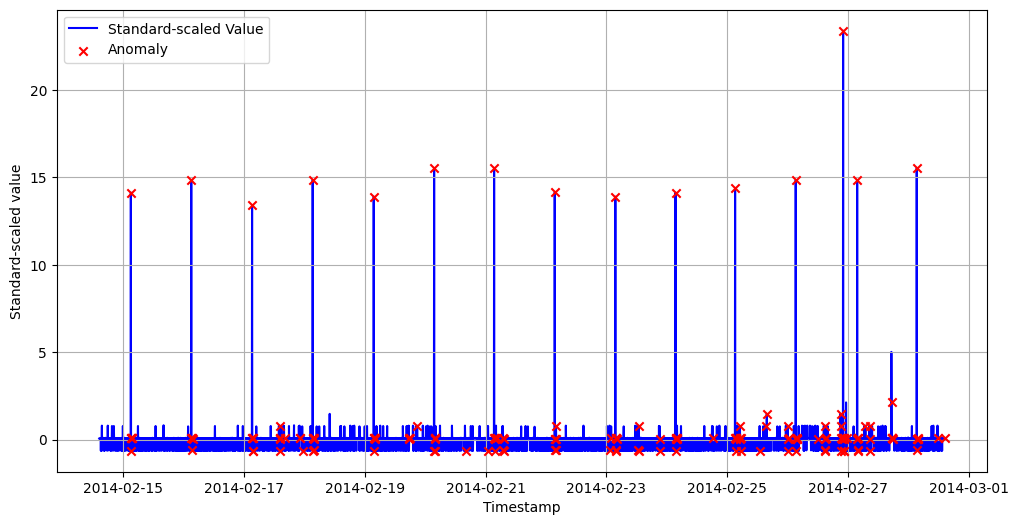

In [100]:
plt.figure(figsize=(12,6))
plt.plot(inp_df['timestamp'], inp_df['std_value'], label='Standard-scaled Value', color='blue', zorder=1)

# Optional: highlight anomalies if you have them
anomalies = inp_df[inp_df['anomaly_window'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['std_value'], 
            color='red', label='Anomaly', marker='x', zorder=2)

plt.xlabel("Timestamp")
plt.ylabel("Standard-scaled value")
plt.legend()
plt.grid(True)
plt.show()
